# Assignment Sheet Python
## Submission deadline 1.6.2021 10:00 a.m.

### Group 4: Anton Georg Schmid, Marina Wurzbacher

In this solution, we focus on the performance of numpy, when trying to use multithreading or multiprocessing. 
This is interesting, as when thinking of python in a numerical context, 

### Exercise 1 - Numerical Integration (8 Points)

Write a Python program that integrates the function
\begin{align}
    f(x,y) = exp(-0.5(x^2+y^2))
\end{align}
in the limits $x \in [-1,1]$ and $y \in [-1,1]$ numerically. To do so, draw a few million random
numbers for each x, y, and z and store these random numbers in arrays. Count, how often
the value of z is less than f(x,y). Choose an appropriate range for z. From the result, estimate
the integral
\begin{align}
    \int_{-1}^1\int_{-1}^1 f(x,y) dx dy
\end{align}

#### a) How long does the integration take without running parallel?

In [3]:
%%timeit
from numpy.random import default_rng
import numpy as np
rng = default_rng()
#help(rng)
n = int(1e7)
pts = rng.uniform(low = -1., high = 1., size = (n,2))
z = rng.random(size = n)
f = np.exp(-0.5* (pts[:,0]**2 + pts[:,1]**2))
eval_array = f > z
lower = np.sum(eval_array)
integral = (lower/n)*4
#print(integral)


598 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


518 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each). Note that numpy is doing some parallelization in the backend, judging by the rise in cpu occupancy on all cores. 

#### b) Rewrite your code using multi-threading. Create 10 threads, each thread processing a certain range of the created points.

In [4]:
%%timeit

import threading
from numpy.random import default_rng
import numpy as np

rng = default_rng()
n = int(1e7)
pts = rng.uniform(low = -1., high = 1., size = (n,2))
z = rng.random(size = n)

def thread_func(x,y,z, results):
    bit = np.exp(-0.5* (x**2 + y**2)) > z
    results.append(np.sum(bit))
    return 


thread_num = 10
chunk_size = n//thread_num
results = []
threads = []


for i in range(thread_num):
    first_index = i * chunk_size
    last_index = (i+1) * chunk_size
    threads.append(threading.Thread(target=thread_func, args=(pts[first_index:last_index,0], 
                                                              pts[first_index:last_index,1], 
                                                              z[first_index:last_index],
                                                              results)))
    threads[i].start()

for i in range(thread_num):
    threads[i].join()

integral = sum(results)/n*4   
#print(integral)

534 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


462 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each). Threading seems to have a slight benefit when using numpy arrays. The reason for this seems to be that the C-code in the backend is only partially affected by the GIL: The python interpreter can move onto annother thread while the backend is still running.


#### c) Now, create a single thread for the evaluation of each random point. Compare the performance to the result from b).

In [5]:
%%timeit
from numpy.random import default_rng
import numpy as np

import threading

rng = default_rng()
n = int(1e3)
pts = rng.uniform(low = -1., high = 1., size = (n,2))
z = rng.random(size = n)

def thread_func(x,y,z, results):
    bit = np.exp(-0.5* (x**2 + y**2)) > z
    results.append(np.sum(bit))
    return 


thread_num = n
chunk_size = n//thread_num
results = []
threads = []


for i in range(thread_num):
    first_index = i * chunk_size
    last_index = (i+1) * chunk_size
    threads.append(threading.Thread(target=thread_func, args=(pts[first_index:last_index,0], 
                                                              pts[first_index:last_index,1], 
                                                              z[first_index:last_index],
                                                              results)))
    threads[i].start()

for i in range(thread_num):
    threads[i].join()

integral = sum(results)/n*4   
#print(integral)

The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate result is being cached.
424 ms ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Your Answer here: This is too slow to get a result. I stopped the evaluation after a minute. When decreasing the problem size by a factor of 1e4 the execution times become similar. Therefore, the overhead seems to be unbearable.

#### d) Rewrite your code using multi-processing. Create a pool and use the Pool.apply, Pool.map or Pool.starmap function. Compare the CPU occupancy for multi-processing and multithreading with a tool like top of htop. How many python processes are running in both cases? Which fraction of CPU time are the processes maximally occupying?

In [6]:
import time

start_time = time.time()

from multiprocessing import Pool
from numpy.random import default_rng
import numpy as np

rng = default_rng()
n = int(1e7)
pts = rng.uniform(low = -1., high = 1., size = (n,2))
z = rng.random(size = n)
pts = np.hstack((pts, z[:,None]))



def pool_func(pts):
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]
    bit = np.exp(-0.5* (x**2 + y**2)) > z
    return np.sum(bit)


pool_size = 2
chunks = 5
chunk_size = n//chunks
results = []
mpPool = Pool(pool_size)

if __name__ == '__main__':
    with mpPool as p:
        result = p.map(pool_func, [pts[i * chunk_size:(i+1) * chunk_size,:] for i in range(chunks)])

mpPool.terminate()

integral = sum(result)/n*4   
print(integral)

end_time = time.time()
print("time elapsed: {}s".format(end_time -start_time) )


2.927882
time elapsed: 1.629289150238037s


Since the "serial" python code using numpy has already been parallelized in the backend, we do not expect any benefits from using multiprocessing. In fact, the execution time for the same problem has become an order of magnitude slower (around 2.5s). Furthermore, the performance seems to be essentially independent of the pool size.

We note that when using multithreading and multiprocessing, all the cores have a similar occupancy rate of close to 100%.
In total, we do not see any benefit from trying to improve on the performance of numpy.

#### e) Change the previous program to use asynchronous execution of parallel processes. Compare the performance between synchronous and asynchronous execution.

In [7]:
import time

start_time = time.time()

from multiprocessing import Pool
from numpy.random import default_rng
import numpy as np

rng = default_rng()
n = int(1e7)
pts = rng.uniform(low = -1., high = 1., size = (n,2))
z = rng.random(size = n)
pts = np.hstack((pts, z[:,None]))



def pool_func(pts):
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]
    bit = np.exp(-0.5* (x**2 + y**2)) > z
    return np.sum(bit)


pool_size = 2
chunks = 5
chunk_size = n//chunks
results = []
mpPool = Pool(pool_size)

if __name__ == '__main__':
    with mpPool as p:
        result = p.map_async(pool_func, [pts[i * chunk_size:(i+1) * chunk_size,:] for i in range(chunks)]).get()

mpPool.terminate()
        
integral = sum(result)/n*4   
print(integral)

end_time = time.time()
print("time elapsed: {}s".format(end_time -start_time) )


2.9284284
time elapsed: 1.8608489036560059s


The asynchronous execution takes 2.5s which is not an improvement over the asynchronous one. In general we would have expected a slight increase in performance, though. This may again be linked to the behaviour of numpy. 

### Exercise 2 - Gaussian Image Filter 2 (7 Points)

Mathematically a Gaussian Blur is defined by:
\begin{align}
    G(x,y) = \frac{1}{2\pi\sigma^2} exp(-\frac{x^2+y^2}{2\sigma^2})
\end{align}
here, $x$ is the distance from the origin on the x-Axis, $y$ is the distance from the origin on the y-Axis, and $\sigma$ is the standard deviation.

If you want to blur an image with $G(x,y)$ you define a Gaussian-Kernel and convolve it with the original image.

You can use the test image I puloaded to Stud.IP.

#### a) Use the above equation to obtain an Gaussian 3x3 Kernel. (If you have problems getting started you may start with an 3x3 Kernel which performs averaging). Then let it run without any parallelization. Plot the unprocessed and the processed image.

(512, 512)


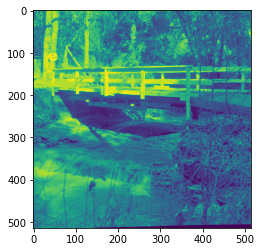

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
im = Image.open('5.2.10.tiff')
imarray = np.array(im)
print(imarray.shape)

imarray = np.pad(imarray, pad_width = ((1, 1), (1, 1)), mode='edge')
plt.imshow(imarray)

In [18]:
#%%timeit

weights = np.ones((3,3))
reg = np.sum(weights)
kernel = (1./reg) *weights

def conv(image, kernel):
    res = image
    shape = image.shape
    #print(shape)
    #print(shape[0])
    res = np.zeros(shape)
    
    for i in range(-1,2):
        for j in range(-1,2):
            #print(i,j)
            xmin = i+1
            xmax = shape[0] -1+i
            ymin = j+1
            ymax = shape[1] -1+j
            res[1:-1,1:-1] += kernel[i+1,j+1] * image[xmin:xmax,ymin:ymax]
            
    return res

convoluted_imarray = conv(imarray, kernel)
#plt.imshow(convoluted_imarray)




#### b) Think about a parallelization strategy. Implement it. Please explain your parallelization strategy, why did you chose Threads/Processes, how did you distribute your computations? How is the performance improvement?

514
time in s:2.5437350273132324
0


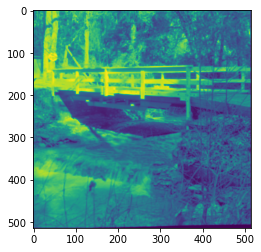

In [19]:
import time

import threading
import numpy as np

def conv_row(image, res, kernel, i):
    for j in range(-1,2):
            #print(i,j)
            xmin = i+1
            xmax = 514-1+i
            ymin = j+1
            ymax = 514-1+j
            res[1:-1,1:-1] += kernel[i+1,j+1] * image[xmin:xmax,ymin:ymax]

def collect_rows(conv_image, res):
    for r in res:
        conv_image += r
    return
            
def conv_parallel(image, kernel, conv_image):
    
    shape = image.shape
    kernel_rows = shape[0]
    print(kernel_rows)
    res = []
    for i in range(kernel_rows):
        res.append(np.zeros(shape))
        res.append(np.zeros(shape))
        res.append(np.zeros(shape))
    
    threads = []
    
    for i in range(-1,2):
        threads.append(threading.Thread(target=conv_row, args=(image,res[i+1], kernel, i)))
        threads[i+1].start()
    
    #print(threads)
    for i in range(3):
        threads[i].join()
    
    collect_rows(conv_image, res)

weights = np.ones((3,3))
reg = np.sum(weights)
kernel = (1./reg) *weights    

conv_image = np.zeros(imarray.shape)

start_time = time.time()

conv_parallel(imarray, kernel, conv_image)
        
end_time = time.time()

print("time in s:{}".format(end_time -start_time))
    
plt.imshow(conv_image)

print(np.sum( (conv_image - convoluted_imarray)**2 > 1e-9)) ##test for bugs. Should show zero, if both implementations work.


The parallelization strategy we tried was to compute the weights for each row in parallel and only then adding the results in a second step. In theory, this should mean, that some of the matrix additions from the serial code could run in parallel using a tree-like parallelism. We decided to use multithreading, as this seems to be more compatible with numpy as explained in exercise 1.

However, the initial numpy code is a factor of 100 faster, executing in about 30.4 ms ± 1.91 ms per loop, while the multithreaded one takes around 2 seconds. While we were not expecting to improve on the simply numpy code very much, the parallelized code should not be that much slower either. Some debugging is required here, we couldn't fix this though. 